In [14]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc

In [2]:
# # Google colab connection
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/dataset.zip"

Streaming output truncated to the last 5000 lines.

  inflating: dataset/0/0_390.jpg     

  inflating: dataset/0/0_391.jpg     

  inflating: dataset/0/0_392.jpg     

  inflating: dataset/0/0_393.jpg     

  inflating: dataset/0/0_394.jpg     

  inflating: dataset/0/0_395.jpg     

  inflating: dataset/0/0_396.jpg     

  inflating: dataset/0/0_397.jpg     

  inflating: dataset/0/0_398.jpg     

  inflating: dataset/0/0_399.jpg     

  inflating: dataset/0/0_4.jpg       

  inflating: dataset/0/0_40.jpg      

  inflating: dataset/0/0_400.jpg     

  inflating: dataset/0/0_401.jpg     

  inflating: dataset/0/0_402.jpg     

  inflating: dataset/0/0_403.jpg     

  inflating: dataset/0/0_404.jpg     

  inflating: dataset/0/0_405.jpg     

  inflating: dataset/0/0_406.jpg     

  inflating: dataset/0/0_407.jpg     

  inflating: dataset/0/0_408.jpg     

  inflating: dataset/0/0_409.jpg     

  inflating: dataset/0/0_41.jpg      

  inflating: dataset/0/0_410.jpg     

  inflating:

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory paths
data_dir = '/kaggle/input/saadnewdataset/dataset'
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator instances for train, validation, and test sets with augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    validation_split=0.3  # Increase validation split to 30%
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 3725 images belonging to 10 classes.
Found 1589 images belonging to 10 classes.


In [31]:
from tensorflow.keras.applications import VGG16,Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

# Load the ResNet50 model pre-trained on ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation='relu')(x)  # Reduce the number of units
x = Dropout(0.5)(x)  # Increase dropout
predictions = Dense(10, activation='softmax')(x)  # Assuming you have 10 classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Make all layers trainable for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50


W0000 00:00:1720207593.265038     535 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/117 ━━━━━━━━━━━━━━━━━━━━ 28s 416ms/step - accuracy: 0.0876 - loss: 2.3575

W0000 00:00:1720207648.998842     533 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.0924 - loss: 2.3455

W0000 00:00:1720207679.912255     534 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720207695.775802     535 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/117 ━━━━━━━━━━━━━━━━━━━━ 185s 893ms/step - accuracy: 0.0925 - loss: 2.3454 - val_accuracy: 0.1359 - val_loss: 2.2974 - learning_rate: 1.0000e-05
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 60s 486ms/step - accuracy: 0.1171 - loss: 2.3018 - val_accuracy: 0.1498 - val_loss: 2.2851 - learning_rate: 1.0000e-05
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 62s 500ms/step - accuracy: 0.1333 - loss: 2.2904 - val_accuracy: 0.2731 - val_loss: 2.2258 - learning_rate: 1.0000e-05
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 62s 499ms/step - accuracy: 0.1717 - loss: 2.2226 - val_accuracy: 0.5154 - val_loss: 1.9547 - learning_rate: 1.0000e-05
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 61s 497ms/step - accuracy: 0.2551 - loss: 2.0576 - val_accuracy: 0.6432 - val_loss: 1.3942 - learning_rate: 1.0000e-05
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 62s 504ms/step - accuracy: 0.3581 - loss: 1.8384 - val_accuracy: 0.7621 - val_loss: 0.9481 - learning_rate: 1.0000e-05
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 62s 503ms/step -

Found 5314 images belonging to 10 classes.
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.9821 - loss: 0.0647


W0000 00:00:1720209851.727705     534 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test accuracy from evaluate: 98.46%
  2/167 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step

W0000 00:00:1720209854.822386     535 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 124ms/step


W0000 00:00:1720209875.349551     536 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy: 0.9845690628528415


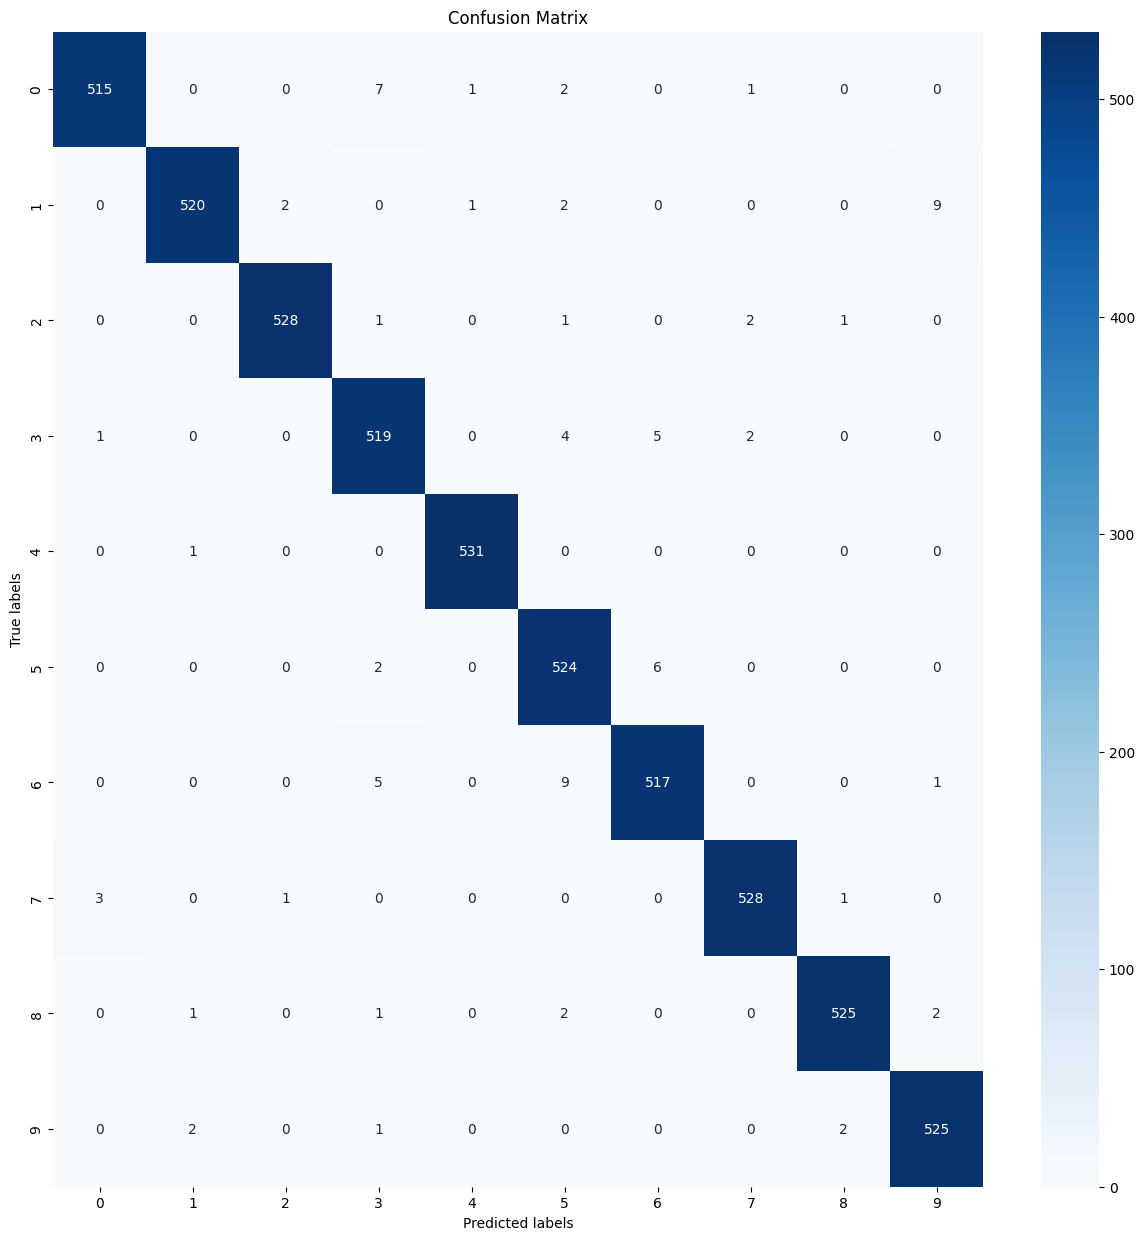

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       526
           1       0.99      0.97      0.98       534
           2       0.99      0.99      0.99       533
           3       0.97      0.98      0.97       531
           4       1.00      1.00      1.00       532
           5       0.96      0.98      0.97       532
           6       0.98      0.97      0.98       532
           7       0.99      0.99      0.99       533
           8       0.99      0.99      0.99       531
           9       0.98      0.99      0.98       530

    accuracy                           0.98      5314
   macro avg       0.98      0.98      0.98      5314
weighted avg       0.98      0.98      0.98      5314

Overall ROC AUC Score: 0.9997722628888926


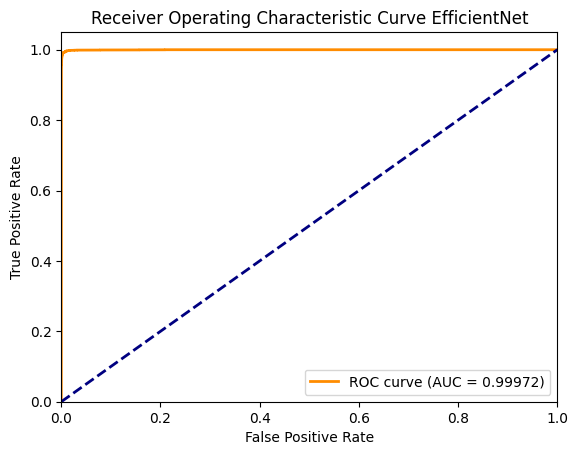

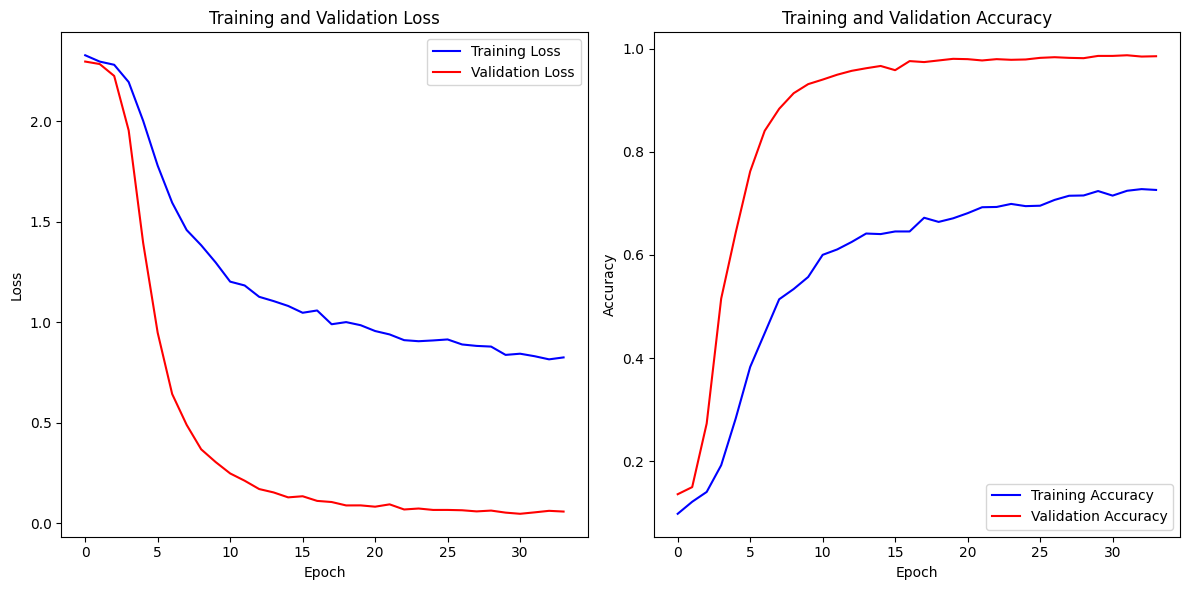

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score

# Recheck Data Generators
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/saadnewdataset/dataset',  # Make sure this directory is correct
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensure no shuffling for consistency in predictions
)

# 1. Evaluate model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy from evaluate: {test_acc * 100:.2f}%')


# Evaluate the model on test set
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy score
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Calculate overall ROC AUC score
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), predictions, average='macro')
print("Overall ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve EfficientNet')
plt.legend(loc="lower right")
plt.show()

# Plot loss and accuracy per epoch
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()